# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
import pandas as pd

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\envs\ipykernel_py2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\envs\ipykernel_py2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034L,)
test label shape: (677L,)
dev label shape: (676L,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [3]:
label_lookup = pd.DataFrame(newsgroups_train.target_names).reset_index()
label_lookup.columns = ['LabelNum','LabelName']

In [4]:
def P1(num_examples=5):
### STUDENT START ###
#Join to add labels
    FiveExamples = pd.concat([pd.DataFrame(train_data).head(num_examples),pd.DataFrame(train_labels).head(num_examples)],axis=1)
    FiveExamples.columns = ['Message','LabelNum']
    result = FiveExamples.merge(label_lookup, on='LabelNum', how='inner')
    print result
### STUDENT END ###
P1(10)

                                             Message  LabelNum  \
0  Hi,\n\nI've noticed that if you only save a mo...         1   
1  \nAcorn Replay running on a 25MHz ARM 3 proces...         1   
2  I'm interested in find out what is involved in...         1   
3  \n\nSeems to be, barring evidence to the contr...         3   
4  \n >In article <1993Apr19.020359.26996@sq.sq.c...         2   
5  AW&ST  had a brief blurb on a Manned Lunar Exp...         2   
6  Mark Prado\n  \n  \nOld pioneer song from the ...         2   
7  \nTheir Hiten engineering-test mission spent a...         2   
8  I have a request for those who would like to s...         0   
9  \nThere are definitely quite a few horrible de...         0   

            LabelName  
0       comp.graphics  
1       comp.graphics  
2       comp.graphics  
3  talk.religion.misc  
4           sci.space  
5           sci.space  
6           sci.space  
7           sci.space  
8         alt.atheism  
9         alt.atheism  


(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [96]:
def P2():
### STUDENT START ###
    cv = CountVectorizer()
    train_CV = cv.fit_transform(train_data)
    #a. use vectorizer properties
    print "a."
    print "Vocabulary size: " + str(train_CV.shape[1])
    print "Non-zero features per sample: " + str(round(float(train_CV.nnz) / (train_CV.shape[0]),4))
    print "Percentage of nonzero elements: " + str(round(float(train_CV.nnz) * 100 / (train_CV.shape[0] * train_CV.shape[1]),4)) + "%"
    
    #b.
    print "b."
    print "word zero: " + cv.get_feature_names()[0]
    print "last word: " + cv.get_feature_names()[len(cv.get_feature_names())-1]
    
    #c.
    print "c."
    truncVocab = ["atheism", "graphics", "space", "religion"]
    trunc_CV = CountVectorizer(vocabulary = truncVocab)
    trunc_Data_CV = trunc_CV.fit_transform(train_data)
    print "Shape of truncated count vectorizer: " + str(trunc_Data_CV.shape)
    print "Non-zero features per sample: " + str(round(float(trunc_Data_CV.nnz) / (trunc_Data_CV.shape[0]),4))
    
    #d.
    print "d."
    ngram_CV = CountVectorizer(ngram_range=(2,3),analyzer='char_wb')
    ngram_CV_Data = ngram_CV.fit_transform(train_data)
    print "Vocabulary of bigrams and trigrams: " + str(ngram_CV_Data.shape[1])
    
    #e.
    print "e."
    cv_min = CountVectorizer(min_df=10)
    train_CV_min = cv_min.fit_transform(train_data)
    print "Vocabulary of words with >10 occurrences: " + str(train_CV_min.shape[1])
    
    #f.
    print "f."
    cv = CountVectorizer()
    train_CV = cv.fit_transform(train_data)
    cv_dev = CountVectorizer()
    cv_dev_data = cv_dev.fit_transform(dev_data)
    dev = cv.get_feature_names()
    trainVocab = cv_dev.get_feature_names()
    
    missingCounter = 0
    for word in dev:
        if word not in trainVocab:
            missingCounter += 1
            
    print "Percentage of dev vocab not in training vocab: " + str(round(float(missingCounter) / cv_dev_data.shape[1],4))
### STUDENT END ###
P2()

a.
Vocabulary size: 26879
Non-zero features per sample: 96.706
Percentage of nonzero elements: 0.3598%
b.
word zero: 00
last word: zyxel
c.
Shape of truncated count vectorizer: (2034, 4)
Non-zero features per sample: 0.2684
d.
Vocabulary of bigrams and trigrams: 28954
e.
Vocabulary of words with >10 occurrences: 3064
f.
Percentage of dev vocab not in training vocab: 0.9024


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

In [6]:
def P3():
### STUDENT START ###
    cv = CountVectorizer()
    train_CV = cv.fit_transform(train_data)
    
    #Using GridSearchCV to find best parameters in each case
    
    KNN_Model = KNeighborsClassifier()
    KNNGridSearch = GridSearchCV(KNN_Model,param_grid={'n_neighbors': [1, 5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175]})
    KNNGridSearch.fit(train_CV,train_labels)
    print pd.DataFrame(KNNGridSearch.grid_scores_)[['parameters', 'mean_validation_score']]
    #shows that the best score could be more than 100 - score still climbing
    print "Best KNN neighbors parameter: "
    print(KNNGridSearch.best_params_)
    KNN_Model = KNeighborsClassifier(n_neighbors = KNNGridSearch.best_params_['n_neighbors'])
    KNN_Model.fit(train_CV,train_labels)
    
    MultiNB = MultinomialNB()
    MultiNBSearch = GridSearchCV(MultiNB,param_grid={'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]})
    MultiNBSearch.fit(train_CV,train_labels)
    print pd.DataFrame(MultiNBSearch.grid_scores_)[['parameters', 'mean_validation_score']]
    print "Best Multinomial NB alpha parameter: "
    print(MultiNBSearch.best_params_)
    MultiNB = MultinomialNB(alpha=MultiNBSearch.best_params_['alpha'])
    MultiNB.fit(train_CV,train_labels)
    
    LR = LogisticRegression(penalty='l2',C=1)
    LRSearch = GridSearchCV(LR,param_grid={'C': np.arange(1,15)})
    LRSearch.fit(train_CV,train_labels)
    print pd.DataFrame(LRSearch.grid_scores_)[['parameters', 'mean_validation_score']]
    #shows that the best score could be less than one - score only drops from 1 onwards
    #will retry the grid search
    LR = LogisticRegression(penalty='l2',C=.1)
    LRSearch = GridSearchCV(LR,param_grid={'C': np.arange(.1,1,step=.1)})
    LRSearch.fit(train_CV,train_labels)
    print pd.DataFrame(LRSearch.grid_scores_)[['parameters', 'mean_validation_score']]
    print "Best LR C parameter: "
    print(LRSearch.best_params_)
    
    LR = LogisticRegression(penalty='l2',C=LRSearch.best_params_['C'])
    LR.fit(train_CV,train_labels)
    
    WeightsDF = pd.DataFrame(columns = ['coefs'], index = np.arange(.1,1,step=.1))
    
    for C in np.arange(.1,1,step=.1):
        LR = LogisticRegression(penalty='l2',C=C)
        LR.fit(train_CV,train_labels)
        WeightsDF[C] = np.sum(np.square(LR.coef_))
    print "C value versus total coefficient squared (part c): "
    print WeightsDF
### STUDENT END ###
P3()

               parameters  mean_validation_score
0     {u'n_neighbors': 1}               0.409046
1     {u'n_neighbors': 5}               0.409046
2    {u'n_neighbors': 10}               0.413471
3    {u'n_neighbors': 20}               0.418879
4    {u'n_neighbors': 30}               0.404621
5    {u'n_neighbors': 40}               0.412488
6    {u'n_neighbors': 50}               0.432153
7    {u'n_neighbors': 75}               0.425270
8   {u'n_neighbors': 100}               0.434612
9   {u'n_neighbors': 125}               0.438053
10  {u'n_neighbors': 150}               0.445919
11  {u'n_neighbors': 175}               0.442970
Best KNN neighbors parameter: 
{'n_neighbors': 150}


C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\envs\ipykernel_py2\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


           parameters  mean_validation_score
0     {u'alpha': 0.0}               0.811701
1  {u'alpha': 0.0001}               0.825467
2   {u'alpha': 0.001}               0.825959
3    {u'alpha': 0.01}               0.828417
4     {u'alpha': 0.1}               0.822026
5     {u'alpha': 0.5}               0.808751
6     {u'alpha': 1.0}               0.795969
7     {u'alpha': 2.0}               0.773845
8    {u'alpha': 10.0}               0.684366
Best Multinomial NB alpha parameter: 
{'alpha': 0.01}
    parameters  mean_validation_score
0    {u'C': 1}               0.763029
1    {u'C': 2}               0.762537
2    {u'C': 3}               0.762537
3    {u'C': 4}               0.761554
4    {u'C': 5}               0.759587
5    {u'C': 6}               0.758112
6    {u'C': 7}               0.757620
7    {u'C': 8}               0.754671
8    {u'C': 9}               0.754179
9   {u'C': 10}               0.754671
10  {u'C': 11}               0.753196
11  {u'C': 12}               0.753196
12

ANSWERS:
a. Nearest neighbors is calculating a vector distance between each training datapoint. Using a simple count vectorizer, simple, uninformative words will confound these vector distances (words like: the, and, it, or).

b. Naive Bayes allows for weighting of words by likelihood of occurrence overall. Logistic regression can only add a linear probably to a cumulative sum based on the presence of a given word. This could be limiting the impact of "rare" words, while Naive Bayes takes full advantage of rare but high information words.

c. In L2 regularization, the magnitude of the coefficients is penalized. When we increase C, we increase the degree to which coefficient magnitude is penalized, and thus the coefficients on each individual word will be dampened to compensate for the increased penalty terms.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [7]:
def P4():
#Unigram
    cv = CountVectorizer()
    train_CV = cv.fit_transform(train_data)

    LR = LogisticRegression(penalty='l2',C=0.2)
    LR.fit(train_CV,train_labels)

    CoefficientMat_Inv = pd.DataFrame(LR.coef_.transpose())
    #identify highest weight words by the top 5 words for each category independently
    Top5Words = np.append(np.append(CoefficientMat_Inv[0].sort_values().head(5).index, CoefficientMat_Inv[1].sort_values().head(5).index),np.append(CoefficientMat_Inv[2].sort_values().head(5).index, CoefficientMat_Inv[3].sort_values().head(5).index))
    Top5_4class = CoefficientMat_Inv.loc[Top5Words]
    Top5_4class.columns = newsgroups_train.target_names
    Top5_4class['words'] = pd.Series(cv.get_feature_names()).loc[Top5Words]
    print "Unigram most important words and weights"
    print Top5_4class
#Bigram
    cv = CountVectorizer(ngram_range=(2,2))
    train_CV = cv.fit_transform(train_data)

    LR = LogisticRegression(penalty='l2',C=0.2)
    LR.fit(train_CV,train_labels)

    CoefficientMat_Inv = pd.DataFrame(LR.coef_.transpose())
    Top5Words = np.append(np.append(CoefficientMat_Inv[0].sort_values().head(5).index, CoefficientMat_Inv[1].sort_values().head(5).index),np.append(CoefficientMat_Inv[2].sort_values().head(5).index, CoefficientMat_Inv[3].sort_values().head(5).index))
    Top5_4class = CoefficientMat_Inv.loc[Top5Words]
    Top5_4class.columns = newsgroups_train.target_names
    Top5_4class['words'] = pd.Series(cv.get_feature_names()).loc[Top5Words]
    print "Bigram most important words and weights"
    print Top5_4class
P4()


C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Unigram most important words and weights
       alt.atheism  comp.graphics  sci.space  talk.religion.misc       words
22567    -0.819150      -0.875358   1.505895           -0.740853       space
24076    -0.520681       0.387669   0.164436           -0.547848      thanks
11552    -0.503243       1.255138  -0.829106           -0.471195    graphics
17609    -0.473431      -0.048886  -0.098170            0.554049       order
5904     -0.442626      -0.218789  -0.277091            0.668053  christians
22567    -0.819150      -0.875358   1.505895           -0.740853       space
11399     0.070047      -0.540518  -0.623287            0.342882         god
26270     0.040889      -0.499824  -0.103209            0.343859         who
18240     0.205676      -0.463732  -0.107726           -0.023516      people
11984     0.021412      -0.434086  -0.219325            0.241276          he
11552    -0.503243       1.255138  -0.829106           -0.471195    graphics
11399     0.070047      -0.540518  

C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ANSWER: The bigrams don't appear particularly informative. While the words selected from the unigram features appear to directly link to the categories, the bigram features don't seem informative towards one class or another at all. It is also interesting that some of the unigrams and bigrams are highly weighted in multiple categories - this could lead to model confusion and misclassification.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [13]:
#nltk gives predefined functions for text cleaning
import nltk
#stemming reduces dimensionality of words
from nltk.stem.porter import *
#can use an NLTK corpus to check if the word is an english word
from nltk.corpus import words
#string functions for manipulations outside of nltk
import string 
#for model performance eval
from sklearn.metrics import accuracy_score, f1_score

def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    #use the porter premade stemmer
    stemmer = PorterStemmer()
    #clear punctuation
    s = ''.join(ch for ch in s if ch not in string.punctuation)
    #replace numbers with numeric token
    s = re.sub("\d{2,10000}", "<NUMTOKEN>", s)
    #stem each word
    s = ''.join(stemmer.stem(w) + " " for w in nltk.word_tokenize(s))
    return s

### STUDENT END ###

def P5():
    ### STUDENT START ###
    cv = CountVectorizer()
    train_CV = cv.fit_transform(pd.Series(train_data).apply(empty_preprocessor))
    LR = LogisticRegression(penalty='l2',C=0.2)
    LR.fit(train_CV,train_labels)
    
    dev_CV = cv.transform(pd.Series(dev_data).apply(empty_preprocessor))
    print "Accuracy with no processing: " + str(round(accuracy_score(dev_labels, LR.predict(dev_CV)),4))
    print "F1 with processing: " + str(round(f1_score(dev_labels, LR.predict(dev_CV),average='macro'),4))
    print "Untransformed data shape: " + str(train_CV.shape)
    
    #reinitialize CV so that we don't have info from previous corpus
    cv = CountVectorizer()
    train_CV = cv.fit_transform(pd.Series(train_data).apply(better_preprocessor))
    LR = LogisticRegression(penalty='l2',C=0.2)
    LR.fit(train_CV,train_labels)
    
    dev_CV = cv.transform(pd.Series(dev_data).apply(better_preprocessor))
    print "Accuracy with processing: " + str(round(accuracy_score(dev_labels, LR.predict(dev_CV)),4))
    print "F1 with processing: " + str(round(f1_score(dev_labels, LR.predict(dev_CV),average='macro'),4))
    print "Transformed data shape: " + str(train_CV.shape)
    ### STUDENT END ###
    

P5()

Accuracy with no processing: 0.713
F1 with processing: 0.6878
Untransformed data shape: (2034, 26879)
Accuracy with processing: 0.7219
F1 with processing: 0.7003
Transformed data shape: (2034, 19835)


ANSWER: By removing punctuation, substituting a token for all numbers above 2 digits in length, and stemming all words, we improve accuracy about slightly more than 1% in the dev set. We improve dev set F1 score by about 1.2%. These changes reduce the features in the vectorizer from 26879 to 19835.

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

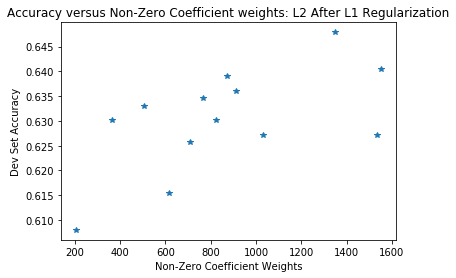

In [47]:
def P6():
    ### STUDENT START ###
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    #iterate over c values to generate variation in coefficient weights for charting
    cVals = np.append(np.arange(0.1,1,step=.1), np.arange(1,5,step=1))
    AccuracyVocabDF = pd.DataFrame(columns=['VocabSize','Accuracy'],index=cVals)
    for c in cVals:
        cv = CountVectorizer()
        train_CV = cv.fit_transform(train_data)
        LR = LogisticRegression(penalty='l1',C=c)
        LR.fit(train_CV,train_labels)
        coefDF = pd.DataFrame(LR.coef_.transpose())
        AccuracyVocabDF.loc[c, 'VocabSize'] = len(coefDF[(coefDF[0] != 0) | (coefDF[1] != 0) | (coefDF[2] != 0) | (coefDF[3] != 0)])
        NonZeroCoeffs = coefDF[(coefDF[0] != 0) | (coefDF[1] != 0) | (coefDF[2] != 0) | (coefDF[3] != 0)].index

        LR = LogisticRegression(penalty='l2',tol=0.1)
        LR.fit(train_CV[:,NonZeroCoeffs],train_labels)

        dev_CV = cv.transform(pd.Series(dev_data).apply(better_preprocessor))
        AccuracyVocabDF.loc[c, 'Accuracy'] = round(accuracy_score(dev_labels, LR.predict(dev_CV[:,NonZeroCoeffs])),4)

    plt.plot(AccuracyVocabDF.VocabSize,AccuracyVocabDF.Accuracy, linestyle='None', marker='*')
    plt.title('Accuracy versus Non-Zero Coefficient weights: L2 After L1 Regularization')
    plt.xlabel('Non-Zero Coefficient Weights')
    plt.ylabel('Dev Set Accuracy')
    

    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [95]:
def P7():
    ### STUDENT START ###
    tfidf = TfidfVectorizer()
    train_tfidf = tfidf.fit_transform(train_data)
    LR = LogisticRegression(C=100)
    LR.fit(train_CV,train_labels)

    dev_tfidf = tfidf.transform(dev_data)
    predictions = LR.predict(dev_tfidf)
    predictions_probs = LR.predict_proba(dev_tfidf)

    Predictions_DF = pd.DataFrame([predictions,predictions_probs,dev_labels]).transpose()
    Predictions_DF.columns = ['predictions','prediction_probabilities','labels']
    Predictions_DF['MaxPredictionProb'] = Predictions_DF.prediction_probabilities.apply(np.amax)

    Predictions_DF['LabelProbability'] = 0
    for index, row in Predictions_DF.iterrows():
        LabelInd = row['labels']
        LabelProb = row['prediction_probabilities'][LabelInd]
        Predictions_DF.loc[index, 'LabelProbability'] = LabelProb

    Predictions_DF['R_Ratio'] = Predictions_DF.MaxPredictionProb / Predictions_DF.LabelProbability
    print "Categories: " + str(newsgroups_train.target_names)
    print "Three worst misclassifications in terms of R Ratio: "
    print Predictions_DF.sort_values(by='R_Ratio',ascending=False).head(3)[['labels','predictions','R_Ratio']]
    print "Text in Three worst Misclassifications: "
    print np.asarray(dev_data)[Predictions_DF.sort_values(by='R_Ratio',ascending=False).head(3).index]
    ### STUDENT END ###
P7()

Categories: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
Three worst misclassifications in terms of R Ratio: 
    labels predictions    R_Ratio
607      0           3  12.174166
215      3           1   7.909815
665      3           1   7.721977
Text in Three worst Misclassifications: 
[u'\nThe 24 children were, of course, killed by a lone gunman in a second story\nwindow, who fired eight bullets in the space of two seconds...\n'
 u'I am pleased to announce that a *revised version* of _The Easy-to-Read Book\nof Mormon_ (former title: _Mormon\'s Book_) by Lynn Matthews Anderson is now\navailable through anonymous ftp (see information below). In addition to the\nchange in title, the revised ETR BOM has been shortened by several pages\n(eliminating many extraneous "that\'s" and "of\'s"), and many (minor) errors\nhave been corrected. This release includes a simplified Joseph Smith Story,\ntestimonies of the three and eight witnesses, and a "Words-to-Know"\nglossary.\

ANSWER: Two of the three worst misclassifications are predictions into label 1 (comp.graphics), when they actually belong to the last label (talk.religion.misc). Reading these texts, the problem is that there are several details about technology (FTP instructions, etc.) are included despite the religious keyword ("Mormon" specifically). To correct for these errors, we would want to increase the weight of the coefficients on words such as "Mormon", while reducing the weights on coefficients of words related to technology independently. I would consider replacing keywords relating to technology with a representative token (similar to the number token used previously). In the TF-IDF methodology, this would increase the document frequency of each individual technology word, so the weight for a word like "ASCII" or "FTP" wouldn't be so independently large and able to collectively change the classification from religion to technology (or at least, would shift the R Ratio downwards).

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance